# Comparing Orbits With and Without Atmospheric Drag Perturbations

#### The following code uses Velocity Verlet to numerically solve for a satellite's position coordinates in 3D. We consider two cases: the first is a 50-orbit simulation with unperturbed motion, and the second is a 50-orbit simulation with atmospheric drag. Both cases include plots of the variation in semimajor axis over time, allowing us to better visualize the effect of atmospheric drag on a circular orbit about jupiter.

#### We first consider 50 orbits with no drag. Our initial conditions are listed below:

$$\begin{equation}
\mu = 0.126687 * 10^9 \ \ \ [\dfrac{kg^3}{s^2}]
\end{equation}$$
$$\begin{equation}
r_o = \begin{bmatrix} 100000.0, & 0., & 0. \end{bmatrix} \ \ \ [km]
\end{equation}$$

#### We calculated velocity with the following equation to ensure a perfectly circular orbit:
$$\begin{equation}
v_{circ} = \sqrt{\dfrac{\mu}{||r_o||}}
\end{equation}$$

$$\begin{equation}
v_o \approx \begin{bmatrix} 0., & v_{circ}, & 0. \end{bmatrix} \ \ \ [\dfrac{km}{s}]
\end{equation}$$

#### Final time was calculated with the period equation:

$$\begin{equation}
t_f = 2\pi\sqrt{\dfrac{||r_o||^3}{\mu}} \ \ \ [s]
\end{equation}$$

# 3D Plot of Satellite Motion - No Drag, Fifty Orbits

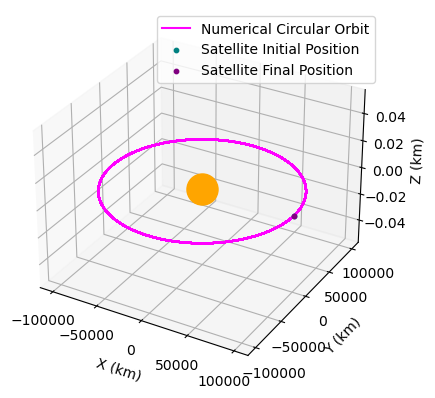

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

# Constants and Parameters
mu = 0.126687e9  # km^3/s^2, Jupiter grav parameter

# Initial Conditions
r_o = np.array([100000.0, 0.0, 0.0])  # km, initial position vector
v_circ = np.sqrt(mu / np.linalg.norm(r_o)) #km/s, circular orbit velocity
v_o = np.array([0.0, v_circ, 0.0])    # km/s, initial velocity vector
t_o = 0                               # s, start time
t_f = 50*(2*np.pi*np.sqrt(np.linalg.norm(r_o)**3/mu)) # s, end time (~245 hrs)
dt = 10.0                             # s, time step
Y_o = np.hstack([r_o, v_o])           # state vector

# Equation of Motion (used for acceleration computation)
def EOM(t, Y):
    r_vec = Y[:3]
    Ydot = np.zeros_like(Y)
    Ydot[:3] = Y[3:]
    r = np.linalg.norm(r_vec)
    a_vec = -mu * r_vec / r**3
    Ydot[3:] = a_vec
    return Ydot

# Velocity Verlet Implementation
def velocity_verlet(r0, v0, t0, tf, dt):
    N = int((tf - t0) / dt) + 1
    r = np.zeros((N, 3))
    v = np.zeros((N, 3))
    t = np.linspace(t0, tf, N)

    r[0] = r0
    v[0] = v0

    # Initial acceleration
    a = -mu * r[0] / np.linalg.norm(r[0])**3

    for i in range(N - 1):
        # Position update
        r[i + 1] = r[i] + v[i] * dt + 0.5 * a * dt**2

        # Compute new acceleration
        a_new = -mu * r[i + 1] / np.linalg.norm(r[i + 1])**3

        # Velocity update
        v[i + 1] = v[i] + 0.5 * (a + a_new) * dt

        # Update acceleration for next step
        a = a_new

    return t, r, v

# Run the Velocity Verlet method
t, r, v = velocity_verlet(r_o, v_o, t_o, t_f, dt)

x = r[:, 0]
y = r[:, 1]
z = r[:, 2]

# Plotting the 3D orbit
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='Numerical Circular Orbit', color='magenta')
ax.scatter(x[0], y[0], z[0], color="teal", s=10, label="Satellite Initial Position")
ax.scatter(x[-1], y[-1], z[-1], color="purple", s=10, label="Satellite Final Position")
ax.scatter(0, 0, 0, color='orange', s=500) #Jupiter
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()
ax.grid(True)
#plt.tight_layout()
plt.show()

### Semimajor Axis Over Time, No Drag

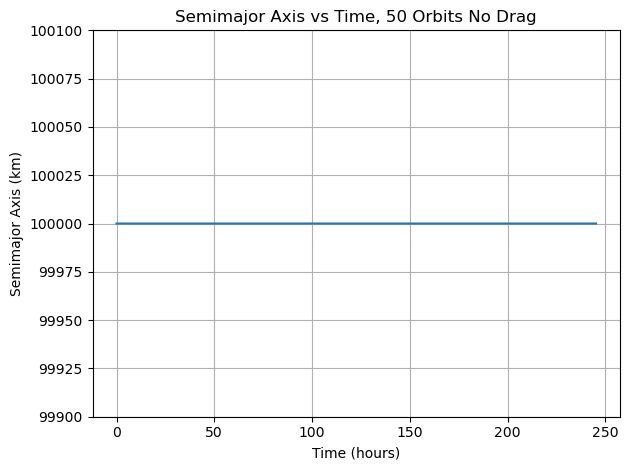

In [6]:
# Plot of semimajor axis
# Compute the semimajor axis over time
r_norm = np.linalg.norm(r, axis=1)
v_norm = np.linalg.norm(v, axis=1)
energy = 0.5 * v_norm**2 - mu / r_norm  # specific orbital energy
a = -mu / (2 * energy)  # semimajor axis in km

# Plot semimajor axis vs time
plt.figure()
plt.plot(t / 3600, a)
plt.xlabel('Time (hours)')
plt.ylabel('Semimajor Axis (km)')
plt.title('Semimajor Axis vs Time, 50 Orbits No Drag')
plt.ylim(np.min(a) * 0.999, np.max(a) * 1.001)  # Narrow y-limits
plt.ticklabel_format(useOffset=False)  # Disable scientific notation
plt.grid(True)
plt.tight_layout()
plt.show()

#### Based on the 3D plot, it can be seen that the initial and final satellite position are the same (the teal initial position dot is under the purple final position dot). This result is as expected because the equation of motion does not account for any perturbations, so the satellite's momentum is conserved. Further, the semimajor axis is constant across all fifty orbits, implying that the satellite remained in a stable circular orbit around Jupiter.

#### Now we will add an atmospheric drag perturbation to the equation of motion function using Cowell's Formulation, as discussed in the derivation section of our report. Some significant assumptions were made to simplify the code. Our assumptions were the following:

- The atmospheric density at our initial position is equal to Jupiter's mean atmospheric density. Density would be lower in reality, but it was difficult to find a Jovian analog to Earth's Standard Atmosphere tables.
- The satellite is a spherical body. This assumption allows us to assume a constant frontal area.
- The diameter and mass of the satellite are equal to that of the Juno spacecraft's bus.
- The drag coefficient of the satellite is comparable to a spherical object in a high Reynold's number flow.

# 3D Plot of Satellite Motion - With Drag, Fifty Orbits

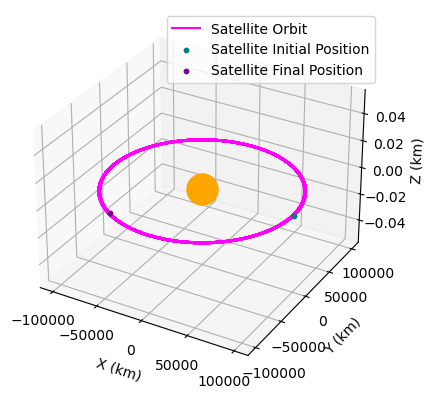

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants and Parameters
mu = 0.126687e9  # km^3/s^2, gravitational parameter
rho = 0.16       # kg/m^3, Jupiter mean atmosphere density
d_sc = 3.5e-3    # km, diameter of spacecraft
m_sc = 1593      # kg, mass of spacecraft
A_sc = np.pi * (d_sc / 2) ** 2  # km^2, frontal area of spacecraft

# Jupiter angular velocity vector
T_jup = 35760                # s, Jupiter sidereal rotation period
omega_z = 2 * np.pi / T_jup  # rad/s, Jupiter rotational velocity
omega_vec = np.array([0.0, 0.0, omega_z])  # rad/s, Jupiter rotational velocity vector

# Drag Coefficient
C_d = 2.2  # Assumed based on high Reynolds number

# Initial Conditions
r_o = np.array([100000.0, 0.0, 0.0])       # km, initial position
v_circ = np.sqrt(mu / np.linalg.norm(r_o)) #km/s, circular orbit velocity
v_o = np.array([0.0, v_circ, 0.0])         # km/s, initial velocity
t_o = 0                                    # s, initial time
t_f = 50*(2*np.pi*np.sqrt(np.linalg.norm(r_o)**3/mu))  # s, end time (~245 hrs)
dt = 10                                    # s, time step

# Equation of Motion with Drag Perturbation
def EOM(r_vec, v_vec):
    r = np.linalg.norm(r_vec)
    v_rel_vec = v_vec - np.cross(omega_vec, r_vec)
    v_rel_mag = np.linalg.norm(v_rel_vec)
    a_vec = (-mu * r_vec / r**3) + (-0.5 * ((C_d * A_sc) / m_sc) * v_rel_mag * rho * v_rel_vec)
    return a_vec

# Velocity Verlet Integration
num_steps = int((t_f - t_o) / dt)
r_values = np.zeros((num_steps, 3))
v_values = np.zeros((num_steps, 3))

r_values[0] = r_o
v_values[0] = v_o

t = t_o
r = r_o
v = v_o

a = EOM(r, v)

for i in range(1, num_steps):
    r_new = r + v * dt + 0.5 * a * dt**2
    a_new = EOM(r_new, v)
    v_new = v + 0.5 * (a + a_new) * dt

    r_values[i] = r_new
    v_values[i] = v_new

    r = r_new
    v = v_new
    a = a_new

x = r_values[:,0]
y = r_values[:, 1]
z = r_values[:, 2]

# Plot orbit
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, color='magenta', label="Satellite Orbit")
ax.scatter(x[0], y[0], z[0], color="teal", s=10, label="Satellite Initial Position")
ax.scatter(x[-1], y[-1], z[-1], color="purple", s=10, label="Satellite Final Position")
ax.scatter(0, 0, 0, color='orange', s=500, marker='o')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.legend()
plt.show()

### Semimajor Axis Over Time, With Drag

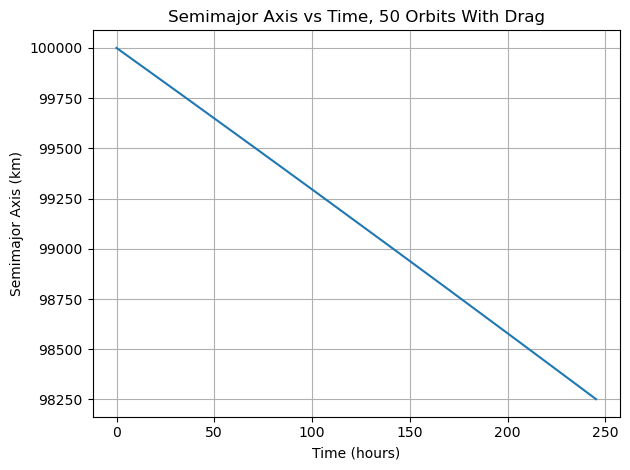

In [8]:
# Compute semimajor axis over time
r_norm = np.linalg.norm(r_values, axis=1)
v_norm = np.linalg.norm(v_values, axis=1)
energy = 0.5 * v_norm**2 - mu / r_norm  # Specific mechanical energy per unit mass
a = -mu / (2 * energy)  # Semimajor axis in km

# Time array
time_array = np.linspace(t_o, t_f, num_steps)

# Plot semimajor axis vs. time
plt.figure()
plt.plot(time_array / 3600, a)  # convert time to hours
plt.xlabel('Time (hours)')
plt.ylabel('Semimajor Axis (km)')
plt.title('Semimajor Axis vs Time, 50 Orbits With Drag')
plt.grid(True)
plt.tight_layout()
plt.show()

#### As expected, the 3D plot of the satellite's motion is noticeably thicker for the perturbed orbit. Unlike in the unperturbed plot, the satellite's final position lags behind the initial position, though both simulations begin with identical initial conditions and plot the same number of orbits. The inclusion of a drag perturbation to the equation of motion produces results which imply that the satellite's momentum was no longer conserved. This conclusion is confirmed with the plot of semimajor axis, which decreases with time. 